In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp 
import tensorflow as tf
import h5py
from sklearn.metrics import roc_curve, auc

import os
os.chdir('..')


2024-08-06 15:00:34.507938: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 15:00:34.555493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX512_FP16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 15:00:35.337969: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from tensorflow.python.training import moving_averages


In [3]:
import math
def mse_loss(y_true, y_pred):
    return tf.math.reduce_mean(tf.math.square(y_pred-y_true), axis=-1)
    
def mse_loss2(y_true,y_pred):

    y_true = tf.squeeze(y_true, axis=-1)
    y_true = tf.cast(y_true, dtype=tf.float32)
    # trick with phi
    y_pred_phi = math.pi*tf.math.tanh(y_pred)
    # trick with phi
    y_pred_eta_egamma = 3.0*tf.math.tanh(y_pred)
    y_pred_eta_muons = 2.1*tf.math.tanh(y_pred)
    y_pred_eta_jets = 4.0*tf.math.tanh(y_pred)
    y_pred_eta = tf.concat([y_pred[:,0:1,:,:], y_pred_eta_egamma[:,1:5,:,:], y_pred_eta_muons[:,5:9,:,:], y_pred_eta_jets[:,9:19,:,:]], axis=1)
    # use both tricks
    y_pred = tf.concat([y_pred[:,:,0,:], y_pred_eta[:,:,1,:], y_pred_phi[:,:,2,:]], axis=2)
    # mask zero features
    #mask = tf.math.not_equal(y_true,0)
    #mask = tf.cast(mask, tf.float32)
    #y_pred = mask * y_pred

    

    loss = masked_mse(tf.expand_dims(y_true, 3), tf.expand_dims(y_pred, 3)) 
    #loss = mse_loss(tf.reshape(y_true, [-1, 57]), tf.reshape(y_pred, [-1, 57]))
    #loss = tf.math.reduce_mean(loss, axis=0) # average over batch
    return loss


def masked_mse(A, B):

    
    
    mask = tf.reduce_all(A[:,:,0] != 0, axis=[2])  
    mask = tf.cast(mask, A.dtype)  
    mask = tf.expand_dims(tf.expand_dims(mask, -1), -1)  


    A_masked = A * mask
    B_masked = B * mask

    squared_diff = tf.square(A_masked - B_masked)


    sum_squared_diff = tf.reduce_sum(squared_diff, axis=[1, 2, 3])  
    sum_mask = tf.reduce_sum(mask, axis=[1, 2, 3])  


    mse = sum_squared_diff / sum_mask

    return mse

In [4]:

class VectorQuantizer(layers.Layer):
    def __init__(self, embedding_dim, num_embeddings, commitment_cost, decay, epsilon=1e-5, **kwargs):
        
        super().__init__(**kwargs)
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        self._decay = decay
        self._commitment_cost = commitment_cost
        self._epsilon = epsilon

        initializer = tf.random_normal_initializer()



        self._w = tf.Variable(
            initial_value=initializer(
                shape=(embedding_dim, num_embeddings), dtype=tf.float32
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

        self._ema_cluster_size = tf.Variable(
            initial_value = tf.zeros_initializer()(shape=(num_embeddings)), dtype=tf.float32,
            name = 'ema_cluster_size'
        )
        
        self._ema_w = tf.Variable(
            initial_value = self._w.value(), dtype=tf.float32,
            name = 'ema_dw'
        )

      
        
    def call(self, inputs, training=False):
        with tf.control_dependencies([inputs]):
            w = self._w.read_value()
        input_shape = tf.shape(inputs)
        with tf.control_dependencies([tf.Assert(tf.equal(input_shape[-1], self._embedding_dim),[input_shape])]):
            flat_inputs = tf.reshape(inputs, [-1, self._embedding_dim])
        
        distances = (tf.reduce_sum(flat_inputs**2, 1, keepdims=True)
                     - 2 * tf.matmul(flat_inputs, w)
                     + tf.reduce_sum(w ** 2, 0, keepdims=True))
        
        encoding_indices = tf.argmax(- distances, 1)
        encodings = tf.one_hot(encoding_indices, self._num_embeddings)
        encoding_indices = tf.reshape(encoding_indices, tf.shape(inputs)[:-1])
        quantized = self.quantize(encoding_indices)

        e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs) ** 2)
        
        if training:
            updated_ema_cluster_size = self._ema_cluster_size.assign(
                self._decay * self._ema_cluster_size + (1 - self._decay) * tf.reduce_sum(encodings, 0))
            dw = tf.matmul(flat_inputs, encodings, transpose_a=True)
            updated_ema_w = self._ema_w.assign(
                self._decay * self._ema_w + (1 - self._decay) * dw)
            n = tf.reduce_sum(updated_ema_cluster_size)
            updated_ema_cluster_size = ((updated_ema_cluster_size + self._epsilon) / (n + self._num_embeddings * self._epsilon) * n)
            normalised_updated_ema_w = (updated_ema_w / tf.reshape(updated_ema_cluster_size, [1, -1]))
            with tf.control_dependencies([e_latent_loss]):
                update_w = self._w.assign(normalised_updated_ema_w)
            with tf.control_dependencies([update_w]):
                loss = self._commitment_cost * e_latent_loss

            
            # updated_ema_cluster_size = moving_averages.assign_moving_average(
            #   self._ema_cluster_size, tf.reduce_sum(encodings, 0), self._decay)
            # dw = tf.matmul(flat_inputs, encodings, transpose_a=True)
            # updated_ema_w = moving_averages.assign_moving_average(self._ema_w, dw,
            #                                                     self._decay)
            # n = tf.reduce_sum(updated_ema_cluster_size)
            # updated_ema_cluster_size = ((updated_ema_cluster_size + self._epsilon)/ (n + self._num_embeddings * self._epsilon) * n)
            
            # normalised_updated_ema_w = (updated_ema_w / tf.reshape(updated_ema_cluster_size, [1, -1]))
            # with tf.control_dependencies([e_latent_loss]):
            #     update_w = tf.assign(self._w, normalised_updated_ema_w)
            # with tf.control_dependencies([update_w]):
            #     loss = self._commitment_cost * e_latent_loss
        
        else:
            loss = self._commitment_cost * e_latent_loss
        
        quantized = inputs + tf.stop_gradient(quantized - inputs)
        avg_probs = tf.reduce_mean(encodings, 0)
        perplexity = tf.exp(- tf.reduce_sum(avg_probs * tf.math.log(avg_probs + 1e-10)))

        self.add_loss(loss)
        
        return quantized
        '''
        return {'quantize': quantized,
                'loss': loss,
                'perplexity': perplexity,
                'encodings': encodings,
                'encoding_indices': encoding_indices,}
        '''
    @property
    def embeddings(self):
        return self._w
        
    def quantize(self, encoding_indices):
        with tf.control_dependencies([encoding_indices]):
            w = tf.transpose(self.embeddings.read_value(), [1, 0])
        return tf.nn.embedding_lookup(w, encoding_indices)
    def compute_output_shape(self, input_shape):
        return input_shape

In [5]:
def get_encoder(latent_dim):
    encoder_inputs = keras.Input(shape=(19, 3, 1))
    x = layers.ZeroPadding2D((1,0))(encoder_inputs)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(16,(3,3), padding = 'valid')(x)
    x = layers.ReLU()(x)
    x = layers.AveragePooling2D((3,1))(x)

    x = layers.Conv2D(32,(3,1), padding = 'same')(x)
    x = layers.ReLU()(x)
    #x = layers.AveragePooling2D((3,1))(x)
    #x = layers.Flatten()(x)

    #x = layers.Dense(latent_dim)(x)

    x = layers.Conv2D(latent_dim, (1,1), padding = 'valid')(x)
    

    return keras.Model(encoder_inputs, x)

def get_decoder(latent_dim):
    print(get_encoder(latent_dim).output.shape[1:])
    latent_inputs = keras.Input(shape=(6,1,latent_dim))#(latent_dim,))#get_encoder(latent_dim).output.shape[1:])
    x = layers.Flatten()(latent_inputs)
    x = layers.Dense(64)(x)
    #x = layers.Dense(64)(latent_inputs)
    x = layers.ReLU()(x)
    x = layers.Reshape((2,1,32))(x)

    x = layers.Conv2D(32, (3,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((3,1))(x)
    x = layers.ZeroPadding2D(((0,0),(1,1)))(x)

    x = layers.Conv2D(16, (3,1), padding='same')(x)
    x = layers.ReLU()(x)
    x = layers.UpSampling2D((3,1))(x)
    x = layers.ZeroPadding2D(((1,0),(0,0)))(x)

    x = layers.Conv2D(1, (3,3), padding='same')(x)
    
    return keras.Model(latent_inputs, x)

def get_vqvae(latent_dim, num_embeddings, commitment_cost, decay):
    vq_layer = VectorQuantizer(latent_dim, num_embeddings, commitment_cost, decay, name="vector_quantizer")
    encoder = get_encoder(latent_dim)
    decoder = get_decoder(latent_dim)
    inputs = keras.Input(shape=(19, 3, 1))
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    return keras.Model(inputs, reconstructions, name="vq_vae")
#print(get_decoder(8).summary())

In [6]:

class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim, num_embeddings, commitment_cost, decay, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings
        

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings, commitment_cost, decay)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with (tf.GradientTape() as tape):
            reconstructions = self.vqvae(x, training=True)
            reconstruction_loss = mse_loss2(x, reconstructions)/self.train_variance
            
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))


        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))


        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

In [7]:
with h5py.File('signals/convolutional_dataset.h5', 'r') as file:
    x_train = np.array(file['X_train'])
    x_test = np.array(file['X_test'])
    x_val = np.array(file['X_val'])

In [8]:
latent_dim = 64
num_embeddings = 512
commitment_cost = 0.25*100
decay = 0.99
output_file = f'results/VQVAEupdatedresults_{latent_dim}_{num_embeddings}'
print(output_file)

results/VQVAEupdatedresults_64_512


In [9]:
data_variance = np.var(x_train)
#8, 32
print(data_variance)

vqvae_trainer = VQVAETrainer(data_variance, latent_dim, num_embeddings, commitment_cost, decay)
vqvae_trainer.compile(optimizer=keras.optimizers.Adam())
vqvae_trainer.fit(x_train, epochs=20, batch_size=1024, callbacks=[
    keras.callbacks.EarlyStopping(monitor='reconstruction_loss', mode='min', patience=5, restore_best_weights=True, min_delta = 0.00),
    keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=3, verbose=1)])
#vqvae_trainer.save("CNN_VQVAE.keras")

0.298068109504151


2024-08-06 15:01:22.780370: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43404 MB memory:  -> device: 0, name: NVIDIA L40, pci bus id: 0000:4a:00.0, compute capability: 8.9
2024-08-06 15:01:22.781892: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 43404 MB memory:  -> device: 1, name: NVIDIA L40, pci bus id: 0000:e1:00.0, compute capability: 8.9


(6, 1, 64)
Epoch 1/20


I0000 00:00:1722956487.520833    1029 service.cc:145] XLA service 0x7f2a4404bf10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722956487.520873    1029 service.cc:153]   StreamExecutor device (0): NVIDIA L40, Compute Capability 8.9
I0000 00:00:1722956487.520877    1029 service.cc:153]   StreamExecutor device (1): NVIDIA L40, Compute Capability 8.9
2024-08-06 15:01:27.580315: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1722956487.657390    1029 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
2024-08-06 15:01:27.830101: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902
I0000 00:00:1722956490.251022    1056 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_753', 16 bytes spill stores, 

  87/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 13.6234 - reconstruction_loss: 13.4516 - vqvae_loss: 0.1717  

I0000 00:00:1722956493.977883    1029 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7077/7094 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3511 - reconstruction_loss: 2.3820 - vqvae_loss: 0.9691

W0000 00:00:1722956506.065611    1031 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert
I0000 00:00:1722956510.095584    1112 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_753', 1052 bytes spill stores, 1116 bytes spill loads



7094/7094 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - loss: 3.3473 - reconstruction_loss: 2.3790 - vqvae_loss: 0.9683 - learning_rate: 0.0010
Epoch 2/20
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.8230 - reconstruction_loss: 0.5068 - vqvae_loss: 0.3162 - learning_rate: 0.0010
Epoch 3/20
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.6547 - reconstruction_loss: 0.4021 - vqvae_loss: 0.2526 - learning_rate: 0.0010
Epoch 4/20
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.5776 - reconstruction_loss: 0.3558 - vqvae_loss: 0.2218 - learning_rate: 0.0010
Epoch 5/20
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.5329 - reconstruction_loss: 0.3264 - vqvae_loss: 0.2065 - learning_rate: 0.0010
Epoch 6/20
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.5159 - reconstruction_loss: 0.3142 - vqvae_loss: 0.2017 - learning_rate: 0.0010
Epoch 7/20
7094/7094 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - loss: 0.5034 - reconstruction_loss: 0.3052 - vqvae_loss: 0.1982 - learning_rate: 0.0

In [10]:
vqvae = vqvae_trainer.vqvae
bkg_prediction = vqvae.predict(x_test)
signal_labels = ["Ato4l", "LQtoBTau","hToTauTau", "hChToTauNu"]
signals_file = ["signals/Ato4l_dataset.h5","signals/LQtoBTau_dataset.h5", "signals/hToTauTau_dataset.h5", "signals/hChToTauNu_dataset.h5"]

signal_data = []
for i, label in enumerate(signal_labels):
    with h5py.File(signals_file[i], 'r') as file:
        test_data = np.array(file['Data'])
    signal_data.append(test_data)
    
signal_results = []
for i, label in enumerate(signal_labels):
    signal_prediction = vqvae.predict(signal_data[i])
    signal_results.append([label, signal_data[i], signal_prediction])

W0000 00:00:1722956820.689005    1030 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


168126/168149 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step

W0000 00:00:1722956963.158153    1029 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


168149/168149 ━━━━━━━━━━━━━━━━━━━━ 145s 847us/step
1728/1750 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step

W0000 00:00:1722957037.262741    1030 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
10642/10642 ━━━━━━━━━━━━━━━━━━━━ 9s 840us/step
21577/21603 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step

W0000 00:00:1722957070.630248    1030 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


21603/21603 ━━━━━━━━━━━━━━━━━━━━ 20s 924us/step
23721/23759 ━━━━━━━━━━━━━━━━━━━━ 0s 835us/step

W0000 00:00:1722957100.738392    1029 assert_op.cc:38] Ignoring Assert operator vq_vae_1/vector_quantizer_1/Assert/Assert


23759/23759 ━━━━━━━━━━━━━━━━━━━━ 22s 922us/step


In [43]:
#print(signal_data[0][0][3])

#print(signal_results[0][2][0][3])

print(x_test[150][0])
print(bkg_prediction[101][0])

[[0.28979359]
 [0.        ]
 [1.43918598]]
[[ 0.21414009]
 [-0.00505253]
 [ 1.7095816 ]]


In [18]:

# with h5py.File(output_file + '.h5', 'w') as file:
#     file.create_dataset('BKG_input', data=x_test)
#     file.create_dataset('BKG_predicted', data=bkg_prediction)
#     for i, sig in enumerate(signal_results):
#         file.create_dataset('%s_input' % sig[0], data=sig[1])
#         file.create_dataset('%s_predicted' % sig[0], data=sig[2])
total_loss = []
total_loss.append(mse_loss2(x_test.astype('float32'), bkg_prediction.astype('float32')).numpy())
for i, signal_X in enumerate(signal_data):
    total_loss.append(mse_loss2(signal_X, signal_results[i][2]).numpy())

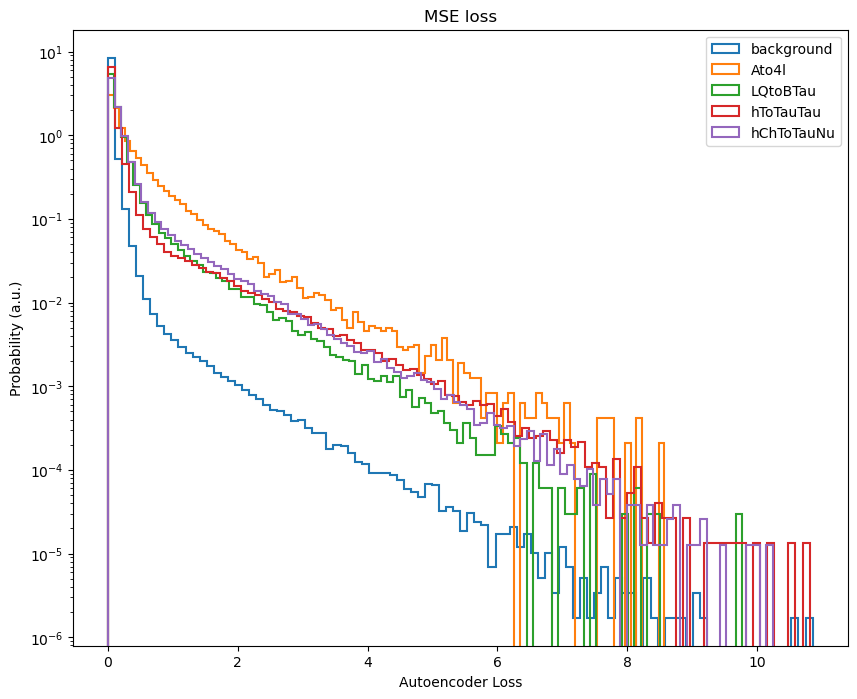

In [19]:
from matplotlib import pyplot as plt

bin_size=100
signal_labels = ["background", "Ato4l", "LQtoBTau", "hToTauTau", "hChToTauNu"]
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5, )#range=[0, 3e4])
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()


Text(0.5, 1.0, 'ROC VQ-VAE, latent_dim = 64, embeddings = 512')

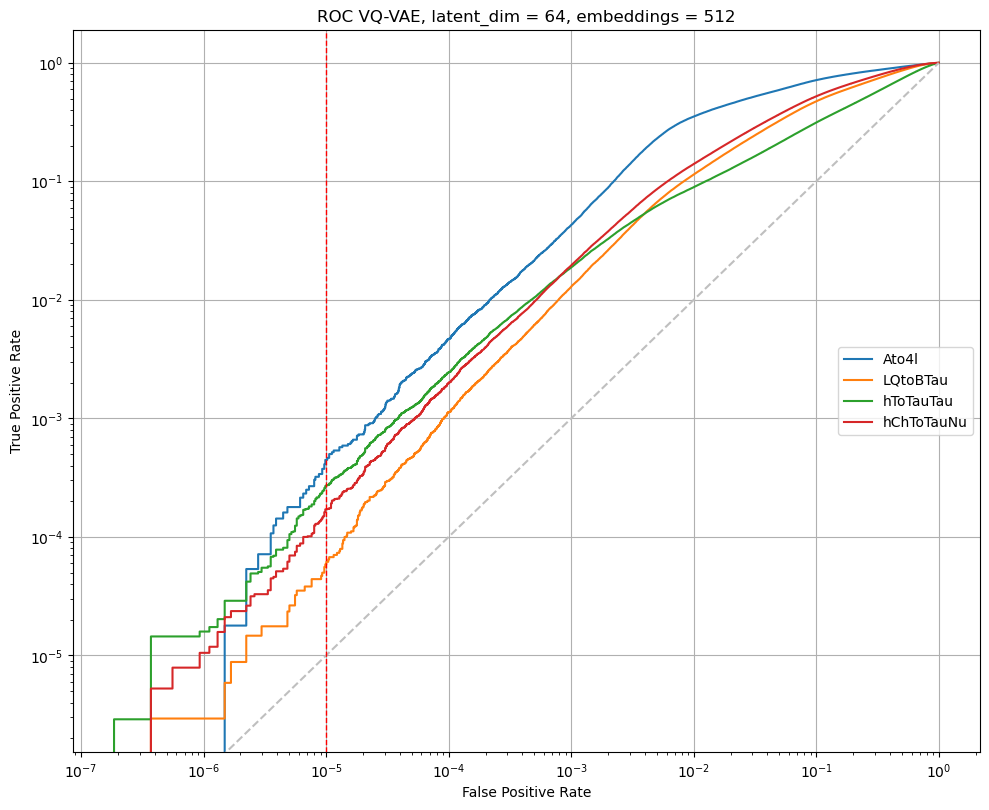

In [20]:
target_background = np.zeros(total_loss[0].shape[0])
#signal_labels = ["background"] + signal_labels
plt.figure(figsize=(10,8))
for i, label in enumerate(signal_labels):
    if i == 0: continue # background events
    
    trueVal = np.concatenate((np.ones(total_loss[i].shape[0]), target_background)) # anomaly=1, bkg=0
    predVal_loss = np.concatenate((total_loss[i], total_loss[0]))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(trueVal, predVal_loss)

    auc_loss = auc(tpr_loss, fpr_loss)
    
    plt.plot(fpr_loss,tpr_loss, "-", linewidth=1.5, label = label)#plt.plot(tpr_loss,fpr_loss, "-", label='%s (auc = %.1f%%)'%(label,auc_loss*100.), linewidth=1.5)
    
    plt.semilogx()
    plt.semilogy()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.legend(loc='center right')
    plt.grid(True)
    plt.tight_layout()
plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')
plt.axvline(0.00001, color='red', linestyle='dashed', linewidth=1) # threshold value for measuring anomaly detection efficiency
plt.title(f"ROC VQ-VAE, latent_dim = {latent_dim}, embeddings = {num_embeddings}")
#plt.savefig(output_file+'_roc.jpg')
#plt.show()
